<h1 style="text-align: center;">Trabalho Computacional - Otimização - 2022.2</p>

**Universidade Federal do Rio de Janeiro - PESC**  
**Professores:** Laura Bahiense e Luidi Simonetti  
**Alunos:** Leonardo Nunes Guimarães Costa e Victor Ribeiro 

## 1 - Objetivo e Especificações


Minimizar computacionalmente a seguinte função:

\begin{equation*}
    f(x_1, x_2) = \sqrt{ln^2(x_1)+ln^2(x_2)} \qquad 
\end{equation*}

### 1.1 - Bibliotecas usadas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from tabulate import tabulate
from random import randint
from operator import add

### 1.2 - Funções Necessárias


#### Calculo da Função em um Ponto

In [2]:
def funcValue(x1, x2):
        return np.sqrt(np.log(x1)**2 + np.log(x2)**2)

#### Calculo do Gradiente em um Ponto


In [3]:
def gradValue(x1,x2):
    denom = funcValue(x1,x2)
    return np.log(x1)/(denom*x1), np.log(x2)/(denom*x2)

#### Calculo da Hessiana em um Ponto


In [4]:
def hessianValue(x1,x2):
    if(x1 <= 0 or x2 <= 0 ): return (np.inf)*3
    log1, log2 = np.log(x1), np.log(x2)
    func, func3 = funcValue(x1,x2), (log1**2 + log2**2)**(1.5)
    a1 = (1/x1**2)*(((1-log1)/(func))-(log1**2/func3))
    a2 = (1/x2**2)*(((1-log2)/(func))-(log2**2/func3))
    b = (-1)*(log1*log2)/(x1*x2*func3)
    return [[a1, b],[b,a2]]

#### Calculo dos Autovalores de uma Matriz

In [5]:
def eigenValues(matrix):
    hdelta, avg = np.sqrt((matrix[0][0]-matrix[1][1])**2 + matrix[0][1]**2)/2, (matrix[0][0] + matrix[1][1])/2
    ev1 = avg + hdelta
    ev2 = avg - hdelta
    return ev1, ev2

#### Direção de um Vetor

In [6]:
def direction(x,y):
    denom = np.sqrt(x**2 + y**2)
    return [x/denom , y/denom]
    

#### Trunco de Float do Python

In [7]:
def truncate(extensive, decimalSize):
    pointer = 0.1**decimalSize
    reduced = (extensive//pointer)*pointer
    residue = extensive - reduced
    return reduced, residue

#### Geração de Tabela comSimulações

In [8]:
def simulate(startingPointList, method, header):
    finalList = []
    for point in startingPointList:
        lineOutput = method(point)
        finalList += [[lineOutput['startingPoint'][0],lineOutput['startingPoint'][1],lineOutput['iterations'],lineOutput['stepSizeCalls'],lineOutput['currentPoint'][0],lineOutput['currentPoint'][1],lineOutput['currentValue'],lineOutput['residual']]]
    finalTable = tabulate(finalList, headers=["X°(x1)","X°(x2)", "#Iteracoes", "#Cham.Armijo", "X*(x1)","X*(x2)", "f(X*)", "Erro de Aproximacao"],floatfmt=[".4f",".4f","","",".6f",".6f",".6f"],tablefmt="fancy_outline")
    print('\n',header,'\n')
    print(finalTable)

#### Geração de Pontos

In [9]:
def getPoint():
    return 1.0/randint(1,10) + 1.0*randint(0,10), 1.0/randint(1,10) + 1.0*randint(0,10)# 82,6% Planalto | 16,8% Paredes | 0,6% Canto

def getCANTO():
    return 1.0/randint(1,100), 1.0/randint(1,100)

def getPAREDE1():
    return 1.0*randint(1,100), 1.0/randint(1,100)

def getPAREDE2():
    return 1.0/randint(1,100), 1.0*randint(1,100)

def getPLANALTO():
    return 1.0*randint(1,500),1.0*randint(1,500) 

### 1.3 - Método para construir gráficos da função

In [10]:
def plotFunction(x1, x2):
    '''Dados os intervalos de x1 e x2, retorna os gráficos e curva de nível da função nesse intervalo.'''
    fig = plt.figure(figsize=(24,8))
    color = 'inferno'

    # First subplot
    ax = fig.add_subplot(1, 3, 1, projection='3d')

    X1 = np.linspace(x1[0], x1[1])
    X2 = np.linspace(x2[0], x2[1])
    X1, X2 = np.meshgrid(X1, X2)
    Z = funcValue(X1, X2)
    ax.plot_surface(X1, X2, Z, rstride=1, cstride=1,
                    cmap=color, edgecolor='none')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('f')
    ax.view_init(25, 35)

    # Second subplot
    ax = fig.add_subplot(1, 3, 2, projection='3d')

    ax.plot_surface(X1, X2, Z, rstride=1, cstride=1,
                    cmap=color, edgecolor='none')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('f')
    ax.view_init(15, 205)


    # Third subplot - Contour line
    ax = fig.add_subplot(1, 3, 3)
    h = ax.contourf(X1, X2, Z, cmap=color)
    plt.axis('scaled')
    fig.colorbar(h, shrink=0.7)
    
    plt.show()

##  2 - Estudo da Função

\begin{equation*}
    f(x_1, x_2) = \sqrt{ln^2(x_1)+ln^2(x_2)} \qquad \Omega = R^2
\end{equation*}

###  2.1 - Regiões e Pontos Críticos

É possível determinar o domínio natural da função como o primeiro quadrante sem valores nulos:

\begin{equation*}
    \Omega = x_1, x_2 > 0
\end{equation*}

Como $x_1$ e $x_2$ apresentam o mesmo comportamento, portanto a função é simétrica para o plano $x_1 = x_2$.

Já que $ln(1) = 0$, é possível observar que $f(x_k,0) = |ln(x_k)|$ o que permite dividir a função em 4 regiões de 3 tipos diferentes:

Para ($ 0 < x_1 < 1$ e $x_2 > 1$) ou ($ 0 < x_2 < 1$ e $x_1 >1$) são as "paredes" da função em que valores próximos dos planos $x_1 = 0$ ou $x_2 = 0$ divergem e de forma oposta ao se aproximar dos planos $x_1 = 1$ ou $x_2 = 1$ a função se aproxima de $ln(x_1)$ ou $ln(x_2)$ dependendo da parede em questão.

Para $ 0 < x_1,x_2 < 1$, é o "canto" da função onde as paredes se unem e seu comportamento é similar ao destas, divergindo na direção da origem e zerando na direção do ponto $(1,1)$.


Como ultimo tipo na região $ x_1,x_2 > 1$ existe o "planalto" que monotonamente diverge para $x_1$ ou $x_2$ crescentes.

Para encontrar os pontos críticos, vamos calcular o gradiente da função.

\begin{equation*}
  \nabla f(x_1, x_2) = \left( \frac{\partial{f(x_1, x_2)}}{\partial{x_1}}, \frac{\partial{f(x_1, x_2)}}{\partial{x_2}} \right)
\end{equation*}

\begin{equation*}
  \nabla f(x_1, x_2) = \left( \frac{\ln(x_1)}{x_1\sqrt{\ln^2(x_1)+\ln^2(x_2)}}, \frac{\ln(x_2)}{x_2\sqrt{\ln^2(x_1)+\ln^2(x_2)}} \right)
\end{equation*}

Para o ponto crítico, devemos encontrar os valores de $ (x_1, x_2) $ em que o numerador seja igual a 0.

\begin{equation*}
    ( \ln(x_1), \ln(x_2) ) = (0,0) \qquad \Rightarrow \qquad (x_1, x_2) = (1,1)
\end{equation*}

Porém os denominadores também são 0 neste ponto, o que caracteriza uma indeterminação e verificando melhor o ponto (1,1) possui uma descontinuidade (de pulo) no gradiente. Não sendo um ponto estacionário e sim um "bico"( descontinuidade de salto) exatamente onde as 4 regiões descritas anteriormente se juntam.

### 2.2 - Convexidade das Regiões

Podemos testar a convexidade das regiões supracitadas uma a uma e a melhor ferramenta para tal é calcular a matriz hessiana da função e verificar nas regiões:

\begin{equation*}
  \nabla² f(x_1, x_2) = 
\end{equation*}

\begin{bmatrix} \frac{1 - ln(x_1)}{x_1² \sqrt{ln²(x_1)+ln²(x_2)}} - \frac{ln²(x_1)}{x_1²(ln²(x_1)+ln²(x_2))^{3/2}} & - \frac{ln(x_1)ln(x_2)}{x_1 x_2(ln²(x_1)+ln²(x_2))^{3/2}}  \\ - \frac{ln(x_1)ln(x_2)}{x_1 x_2(ln²(x_1)+ln²(x_2))^{3/2}} & \frac{1 - ln(x_2)}{x_2² \sqrt{ln²(x_1)+ln²(x_2)}} - \frac{ln²(x_2)}{x_2²(ln²(x_1)+ln²(x_2))^{3/2}} \end{bmatrix}



Aplicando a hessiana à parede $x_1 > 1$  $\&$  $1 > x_2 > 0$ :

A matriz não é definida (ilustrar) e por simetria a outra ragião de parede também não, não sendo convexas.


Aplicando à região de planalto $x_1, x_2 >1$ :

A matriz é definida negativa (ilustrar) portando côncava(não convexa).

Aplicando à região de canto $0 < x_1,x_2 < 1$ :

A matriz é definida positiva(ilustrar), portanto a única região convexa da função.

### 2.3 - Visualização da Função

#### A Região do Canto:

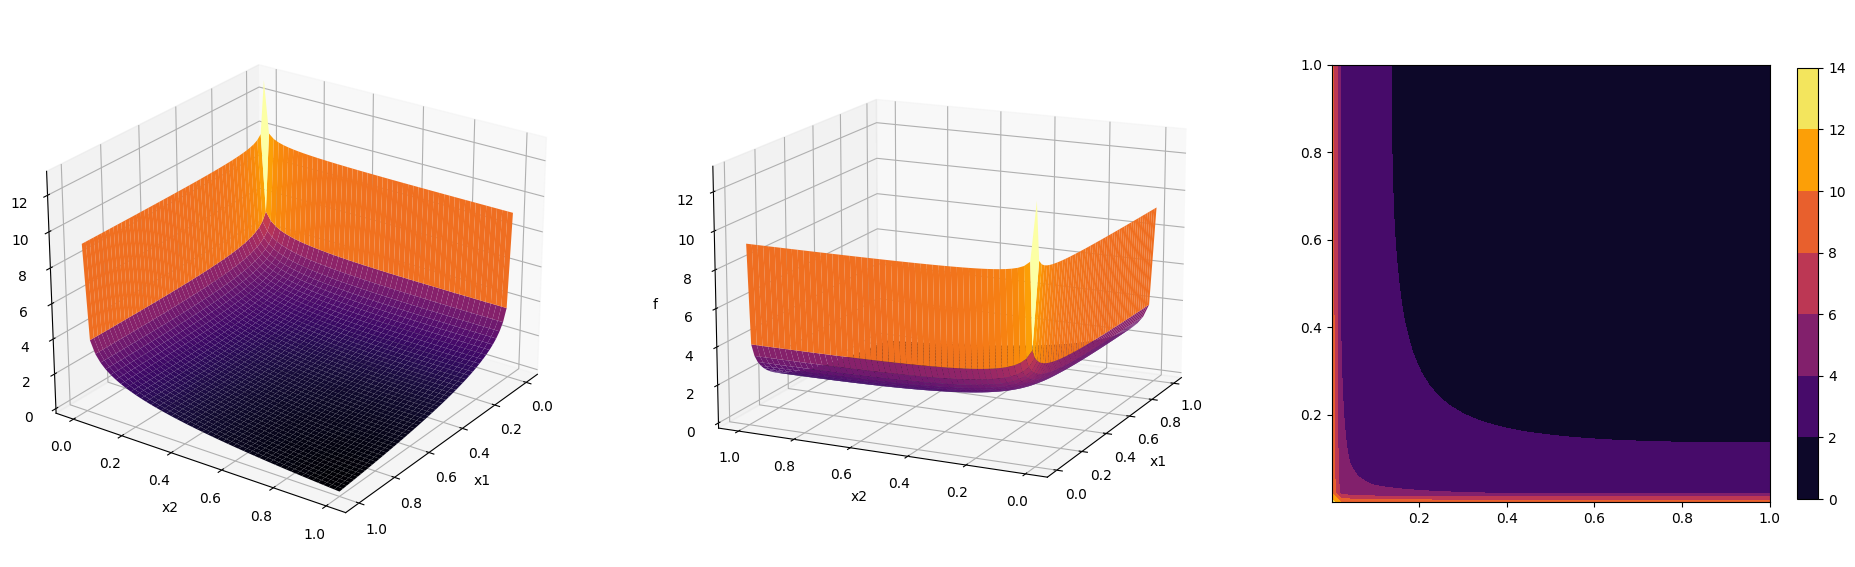

In [11]:
plotFunction(x1=[0.0001, 1.0], x2=[0.0001, 1.0])

#### A Parede ao Longo de $x_1$

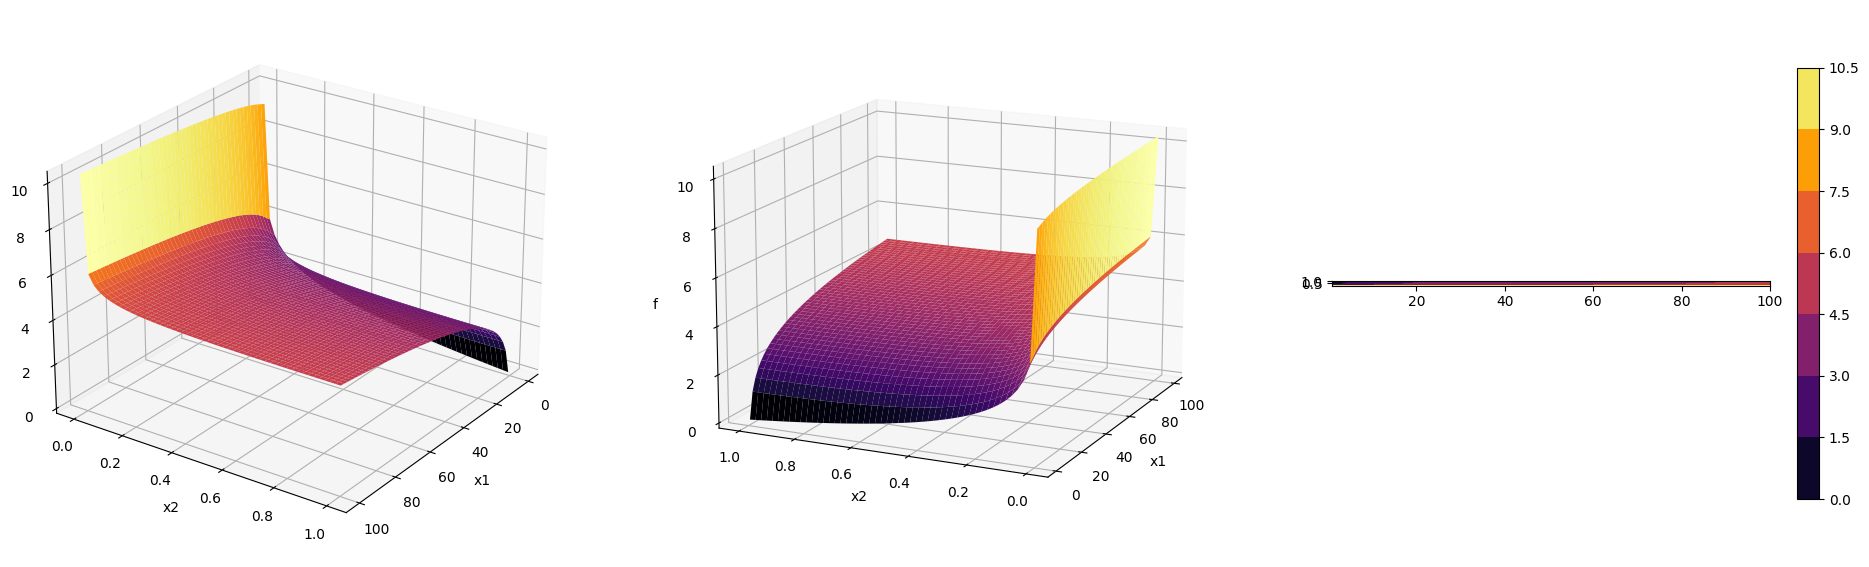

In [12]:
plotFunction(x1=[1.0, 100.0], x2=[0.0001, 1.0])

#### A Região do Planalto

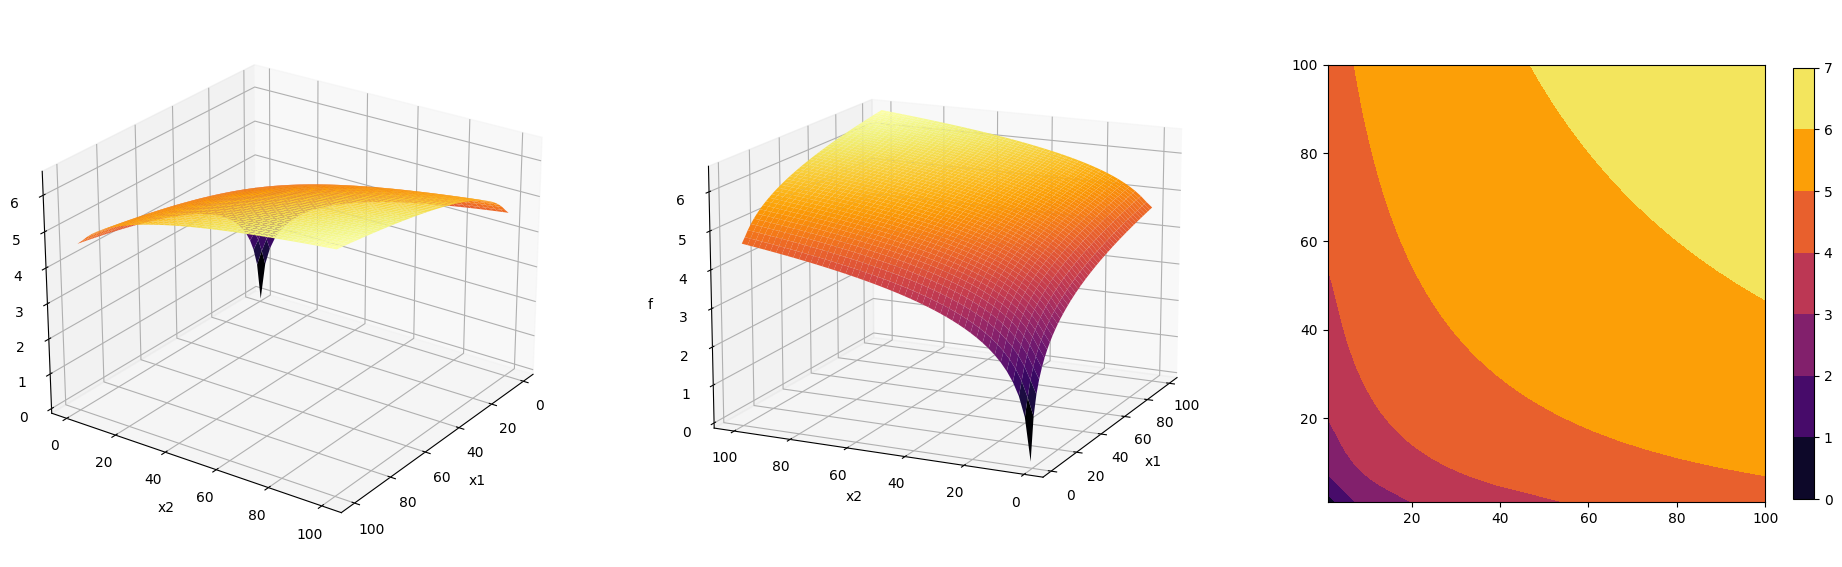

In [13]:
plotFunction(x1=[1.0, 100.0], x2=[1.0, 100.0])

Para compreender melhor o comportamento da função, foram utilizados os gráficos e curvas de nível abaixo, incluindo trechos das 4 regiões.

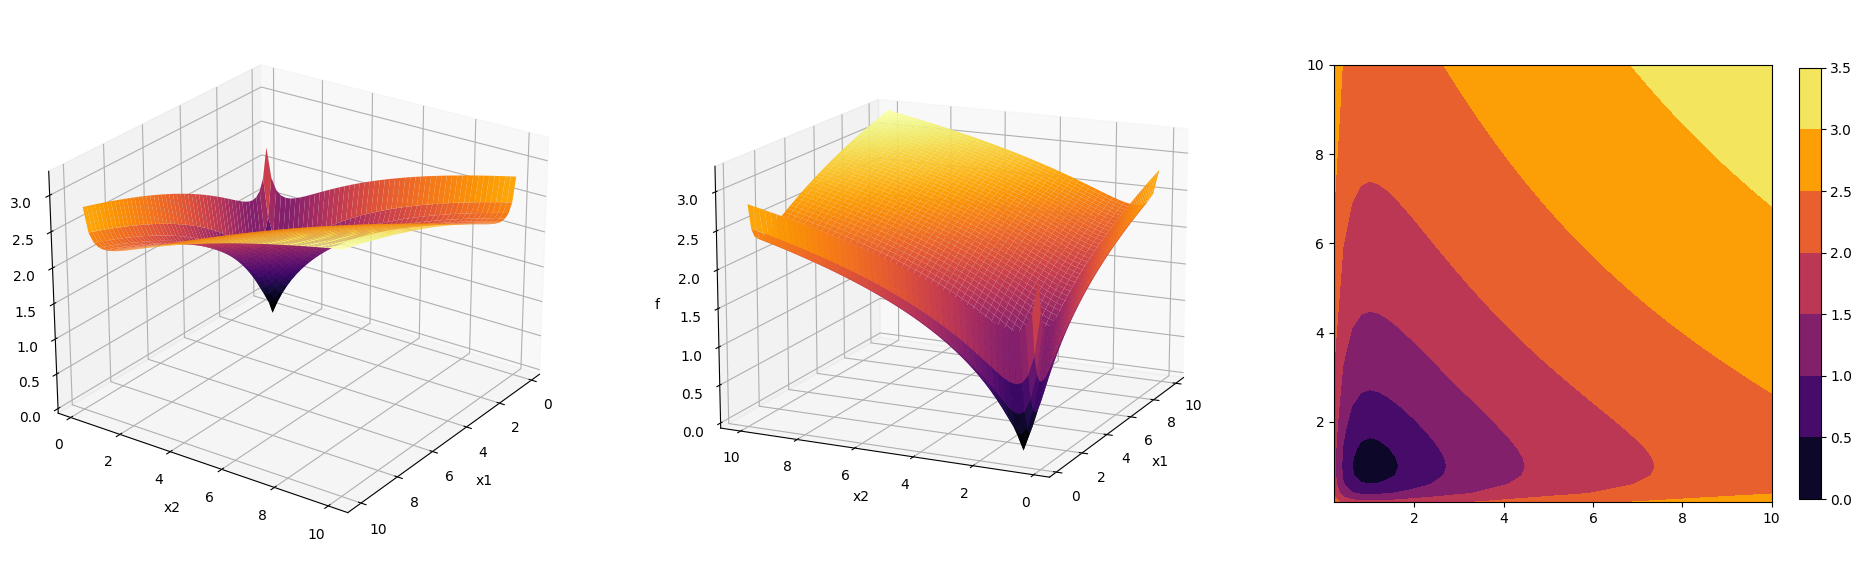

In [14]:
plotFunction(x1=[0.2, 10], x2=[0.2, 10])

Aproximando do bico em $(1,1)$

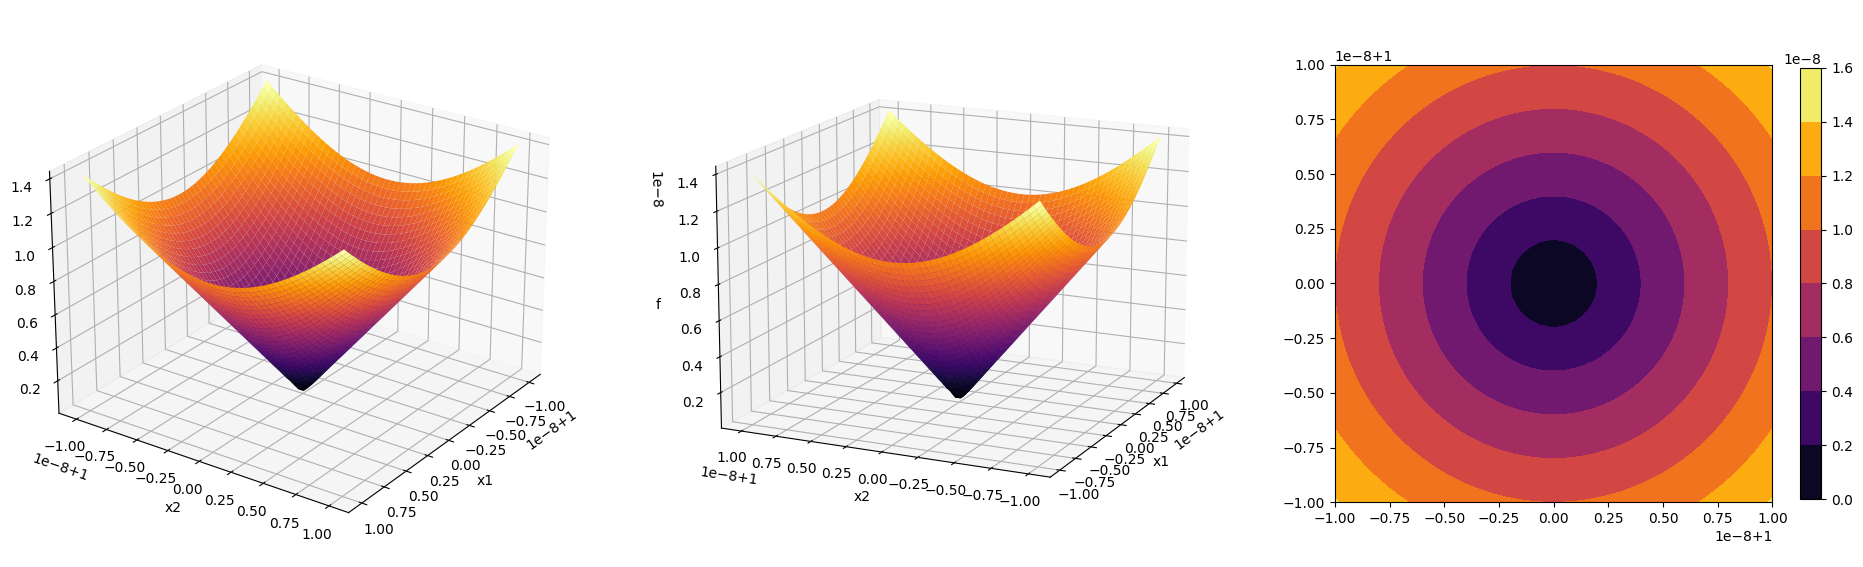

In [15]:
plotFunction(x1=[0.99999999, 1.00000001], x2=[0.99999999, 1.00000001])

## 3 - Implementação dos Métodos


### 3.1 - Tamanho de Passo pela Regra de Armijo

Tendo a direção de decrescimento e três parâmetros numéricos $S > 0$ e 0 < $\beta, \sigma < 1$ e também considerado um limite para as iterações:

In [16]:
def stepSize(state,direction, S , beta , sigma ,m = 0, iterationCap = 100):
    iterationRem = iterationCap - 1
    if iterationRem < 1:
        return stepSize(state,direction,np.sqrt(S),beta,sigma**2)
    state['stepSizeCalls'] += 1
    stepLength = sigma*(beta**m)*S
    newPoint = list(map(add,list(state['currentPoint']),[i * stepLength for i in list(direction)]))
    if(newPoint[0] > 0 and newPoint[1] > 0): 
        newValue = funcValue(newPoint[0],newPoint[1]) 
    else: newValue = np.inf
    
    if(state['currentValue'] < newValue):
        m += 1
        return stepSize(state, direction, S, beta, sigma, m, iterationRem)
    else:
        state['currentPoint'] = (newPoint[0],newPoint[1])
        state['currentValue'] = newValue
        return state, stepLength

### 3.2 - Método do Gradiente

In [17]:
def gradientMethod(startingPoint, iteractionCap = 10000, epsolon = .000001, S = 2.34, beta = .45, sigma = .1):
    state = {'startingPoint': startingPoint, 'iterations': 0, 'stepSizeCalls': 0, 'currentPoint': startingPoint, 'currentValue': funcValue(startingPoint[0],startingPoint[1]), 'residual': 0}
    searching = True
    stepDiff = S
    while(searching):
        state['iterations'] += 1
        point = state['currentPoint']
        startingValue = state['currentValue']
        grdientValue = gradValue(point[0],point[1])
        descendValue = [i *(-1) for i in grdientValue]
        descendDirection = direction(descendValue[0],descendValue[1])
        state, stepDiff = stepSize(state, descendDirection,stepDiff * 10, beta, sigma)
        if state['iterations'] > iteractionCap: 
            searching = False 
        valueDiff = startingValue - state['currentValue']
        if ( valueDiff < epsolon and stepDiff < epsolon ): 
            searching = False   
    splitValue = truncate(state['currentValue'],6)
    state['currentValue'] = splitValue[0]
    state['residual'] = splitValue[1]
    return state

 ### 3.3.a - Método de Newton ( Com Problemas de Convergência)

In [18]:
def newtonMethodBroken(startingPoint, iteractionCap = 10000, epsolon = 0.00000001, S = 1.15, beta = .1, sigma = .1):
    state = {'startingPoint': startingPoint, 'iterations': 0, 'stepSizeCalls': 0, 'currentPoint': startingPoint, 'currentValue': funcValue(startingPoint[0],startingPoint[1]), 'residual': 0}
    searching = True
    stepDiff = S
    while(searching):
        state['iterations'] += 1
        point = state['currentPoint']
        startingValue = state['currentValue']
        gradientValue = gradValue(point[0],point[1])
        hessian = hessianValue(point[0],point[1])
        inverted = np.linalg.inv(hessian)
        descendValue = np.dot(inverted, gradientValue)
        descendDirection = direction(descendValue[0],descendValue[1])
        #print(point, "       ",descendDirection)
        state, stepDiff = stepSize(state, descendDirection,stepDiff * 10, beta, sigma)
        #print(point) - #pra ver o ponto se aproximar do otimo
        if state['iterations'] > iteractionCap: 
            searching = False 
            print('iteration limit')
        valueDiff = startingValue - state['currentValue']
        #print(valueDiff,stepDiff)
        if ( valueDiff < epsolon and stepDiff < epsolon ):
            #print("=====")
            #print(valueDiff,stepDiff) 
            searching = False
            #print("optimal")
    
    splitValue = truncate(state['currentValue'],6)
    state['currentValue'] = splitValue[0]
    state['residual'] = splitValue[1]
    return state

 ### 3.3.b - Método de Newton ( Ajustado)

In [19]:
def newtonMethod(startingPoint, iteractionCap = 10000, epsolon = 0.00000001, S = 1.15, beta = .1, sigma = .1):
    state = {'startingPoint': startingPoint, 'iterations': 0, 'stepSizeCalls': 0, 'currentPoint': startingPoint, 'currentValue': funcValue(startingPoint[0],startingPoint[1]), 'residual': 0}
    searching = True
    stepDiff = S
    while(searching):
        state['iterations'] += 1
        point = state['currentPoint']
        startingValue = state['currentValue']
        gradientValue = gradValue(point[0],point[1])
        hessian = hessianValue(point[0],point[1])
        inverted = np.linalg.inv(hessian)
        descendValue = np.dot(inverted, gradientValue)
        switches = [1,1]
        if point[0] > 1: switches[0] = -1
        if point[1] > 1: switches[1] = -1
        descendDirection = direction(np.sqrt(descendValue[0]**2)*switches[0],np.sqrt(descendValue[1]**2)*switches[1])
        #print(point, "       ",descendDirection)
        state, stepDiff = stepSize(state, descendDirection,stepDiff * 10, beta, sigma)
        #print(point) - #pra ver o ponto se aproximar do otimo
        if state['iterations'] > iteractionCap: 
            searching = False 
            print('iteration limit')
        valueDiff = startingValue - state['currentValue']
        #print(valueDiff,stepDiff)
        if ( valueDiff < epsolon and stepDiff < epsolon ):
            #print("=====")
            #print(valueDiff,stepDiff) 
            searching = False
            #print("optimal")
    
    splitValue = truncate(state['currentValue'],6)
    state['currentValue'] = splitValue[0]
    state['residual'] = splitValue[1]
    return state

### 3.4 - Método BFGS

In [20]:
#TODO

### 3.5 - Método das 4 Direções (extra, brincadeira com o passo de Armijo)

In [21]:
def mockMethod2(startingPoint, iteractionCap = 10000, epsolon = .000001, S = 1.3, beta = .4, sigma = .1):
    state = {'startingPoint': startingPoint, 'iterations': 0, 'stepSizeCalls': 0, 'currentPoint': startingPoint, 'currentValue': funcValue(startingPoint[0],startingPoint[1]), 'residual': 0}
    searching = True
    stepDiff = S
    while(searching):
        state['iterations'] += 1
        startingValue = state['currentValue']
        west, east, north, south = [-1,0], [1,0], [0,1], [0,-1]
        westStep, eastStep, northStep, southStep = stepSize(state, west,stepDiff * 10, beta, sigma), stepSize(state, east,stepDiff * 10, beta, sigma),stepSize(state, north,stepDiff * 10, beta, sigma), stepSize(state, south,stepDiff * 10, beta, sigma)
        larger = ({},0)
        for step in [westStep, eastStep, northStep, southStep]:
            if step[1] > larger[1]: larger = step
       
        
        state, stepDiff = larger[0],larger[1]
        #print(point) - #pra ver o ponto se aproximar do otimo
        if state['iterations'] > iteractionCap: 
            searching = False 
            #print('iteration limit')
        valueDiff = startingValue - state['currentValue']
        if ( valueDiff < epsolon and stepDiff < epsolon ): 
            searching = False
            #print("optimal")
    
    splitValue = truncate(state['currentValue'],6)
    state['currentValue'] = splitValue[0]
    state['residual'] = splitValue[1]
    return state


## 4 - Resultados

Gerando Pontos aleatórios nas 4 regiões:

In [22]:
canto, parede1, parede2, planalto, randomPoint = getCANTO(), getPAREDE1(), getPAREDE2(), getPLANALTO(), getPoint()

print(canto)
print(parede1)
print(parede2)
print(planalto)
print(randomPoint)

(0.023255813953488372, 0.013513513513513514)
(2.0, 0.021739130434782608)
(0.01020408163265306, 15.0)
(418.0, 301.0)
(3.5, 2.142857142857143)


### 4.1 - Problemas de Convergência do Método de Newton

In [25]:
simulate([canto,parede1,parede2,planalto,randomPoint],newtonMethodBroken,"TABELA 1\n\nMÉTODO DE NEWTON SEM AJUSTES")



 TABELA 1

MÉTODO DE NEWTON SEM AJUSTES 

╒══════════╤══════════╤══════════════╤════════════════╤══════════╤══════════╤══════════╤═══════════════════════╕
│   X°(x1) │   X°(x2) │   #Iteracoes │   #Cham.Armijo │   X*(x1) │   X*(x2) │    f(X*) │   Erro de Aproximacao │
╞══════════╪══════════╪══════════════╪════════════════╪══════════╪══════════╪══════════╪═══════════════════════╡
│   0.0233 │   0.0135 │            1 │             19 │ 0.023256 │ 0.013514 │ 5.715907 │           8.57623e-07 │
│   2.0000 │   0.0217 │            1 │             16 │ 2.000000 │ 0.021739 │ 3.890880 │           1.00546e-07 │
│   0.0102 │  15.0000 │            7 │             19 │ 0.007621 │ 8.100000 │ 5.306610 │           7.7563e-08  │
│ 418.0000 │ 301.0000 │          459 │            476 │ 0.995514 │ 0.996983 │ 0.005416 │           6.57287e-07 │
│   3.5000 │   2.1429 │            5 │             22 │ 0.888224 │ 1.105141 │ 0.155062 │           6.62453e-08 │
╘══════════╧══════════╧══════════════╧═══════════════

### 4.2 - Simulção dos Métodos Ajustados

In [24]:
simulate([canto,parede1,parede2,planalto,randomPoint],gradientMethod,"TABELA 2\n\nMÉTODO GRADIENTE")

simulate([canto,parede1,parede2,planalto,randomPoint],newtonMethod,"TABELA 3\n\nMÉTODO DE NEWTON")

simulate([canto,parede1,parede2,planalto,randomPoint],mockMethod2,"TABELA 5\n\nMÉTODO DAS 4 DIREÇÕES")


 TABELA 2

MÉTODO GRADIENTE 

╒══════════╤══════════╤══════════════╤════════════════╤══════════╤══════════╤══════════╤═══════════════════════╕
│   X°(x1) │   X°(x2) │   #Iteracoes │   #Cham.Armijo │   X*(x1) │   X*(x2) │    f(X*) │   Erro de Aproximacao │
╞══════════╪══════════╪══════════════╪════════════════╪══════════╪══════════╪══════════╪═══════════════════════╡
│   0.0233 │   0.0135 │           13 │             32 │ 1.000000 │ 1.000000 │ 0.000000 │           1.2509e-07  │
│   2.0000 │   0.0217 │           16 │             36 │ 1.000000 │ 1.000000 │ 0.000000 │           1.08838e-07 │
│   0.0102 │  15.0000 │           43 │             63 │ 1.000000 │ 1.000000 │ 0.000000 │           4.75403e-08 │
│ 418.0000 │ 301.0000 │         4103 │           4122 │ 1.000000 │ 1.000000 │ 0.000000 │           8.47423e-09 │
│   3.5000 │   2.1429 │           13 │             36 │ 1.000000 │ 1.000000 │ 0.000000 │           9.55053e-09 │
╘══════════╧══════════╧══════════════╧════════════════╧══════════